In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
# Set choice of parameters.

gamma_a = 3.5
gamma_b = 0.8
sigma = 3

In [3]:
def gamma_jax(x, a, b):
    return b**a / jax.scipy.special.gamma(a) * x**(a-1) * jnp.exp(-b*x)

@jax.jit
def gamma_conv_jax(x, a, b, sigma=3):
    '''
    Implements convolution of gamma distribution with a normal distribution.
    Such distribution arises from adding gaussian noise to samples from a gamma distribution.
    See eq. 7 of arXiv:0704.1706 [astro-ph].
    '''
    eta = b*sigma - x/sigma
    s_eta_sq = 0.5 * eta**2 # argument to hyp1f1 is always positive.
    
    fac1 = (b**a * sigma **(a-1) * jnp.exp(-0.5*(x/sigma)**2)) / 2**(0.5*(1+a))
    s1 = jax.scipy.special.hyp1f1(0.5*a, 0.5, s_eta_sq) / jax.scipy.special.gamma(0.5*(a+1))
    s2 = jax.scipy.special.hyp1f1(0.5*(a+1), 3./2., s_eta_sq) / jax.scipy.special.gamma(0.5*a)
    return fac1 * (s1 - np.sqrt(2)*eta*s2)

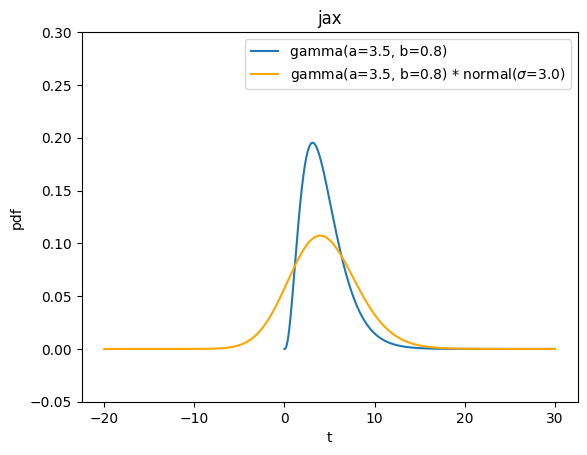

In [4]:
xvals = jnp.linspace(-20, 30, 10000)
yvals_jax = gamma_jax(xvals, gamma_a, gamma_b)
yvals_conv_jax = gamma_conv_jax(xvals, gamma_a, gamma_b, sigma=sigma)

fig, ax = plt.subplots()
ax.plot(xvals, yvals_jax, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.plot(xvals, yvals_conv_jax, 
        label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='orange')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.set_ylim([-0.05, 0.3])
ax.legend()
ax.set_title('jax')
plt.show()

In [12]:
@jax.jit
def gamma_conv_jax_region4(x, a, b, sigma=3):
    # arXiv:0704.1706, eq. 13
    # https://github.com/icecube/icetray/blob/e773449cfbb9e505dbcdeb3ae84242505fb7f253/rpdf/private/rpdf/pandel.cxx#L237
    # t <= rho sigma^2, a >= 1
    # Note: a := ksi
    M_SQRTPI = jnp.sqrt(np.pi)
    M_E = jnp.exp(1.0)
    M_SQRT2 = jnp.sqrt(2.0)
    rhosigma = b*sigma
    eta = rhosigma - x/sigma
    ksi21 = 2.*a - 1
    ksi212 = ksi21*ksi21
    ksi213 = ksi212*ksi21
    z = jnp.fabs(eta)/jnp.sqrt(2.*ksi21)
    sqrt1plusz2 = jnp.sqrt(1 + z*z)
    k = 0.5*(z*sqrt1plusz2 + jnp.log(z+sqrt1plusz2))
    beta=0.5*(z/sqrt1plusz2 - 1.)
    beta2 = beta*beta
    beta3 = beta2*beta
    beta4 = beta3*beta
    beta5 = beta4*beta
    beta6 = beta5*beta
    n1 = (20.*beta3 + 30.*beta2 + 9.*beta)/12.
    n2 = (6160.*beta6 + 18480.*beta5 + 19404.*beta4 + 8028.*beta3 + 945.*beta2)/288.
    n3 = (27227200.*beta6 + 122522400.*beta5 + 220540320.*beta4 + 200166120.*beta3 +\
          94064328.*beta2 + 20546550.*beta + 1403325.)*beta3/51840.

    sigma2 = sigma*sigma
    delay2 = x*x
    eta2 = eta*eta
    
    u = jnp.power(2.*M_E/ksi21, a/2.)*jnp.exp(-0.25)/M_SQRT2
    psi = 1. + n1/ksi21 + n2/ksi212 + n3/ksi213
    cpandel= jnp.power(rhosigma, a)/sigma * jnp.exp(-0.5*delay2/sigma2+0.25*eta2) / (M_SQRT2*M_SQRTPI)

    return  cpandel * u * jnp.exp(-k*ksi21) * psi / jnp.sqrt(sqrt1plusz2)

In [13]:
xvals = jnp.linspace(-20, 30, 10000)
yvals_conv_jax_region4 = gamma_conv_jax_region4(xvals, gamma_a, gamma_b, sigma=sigma)

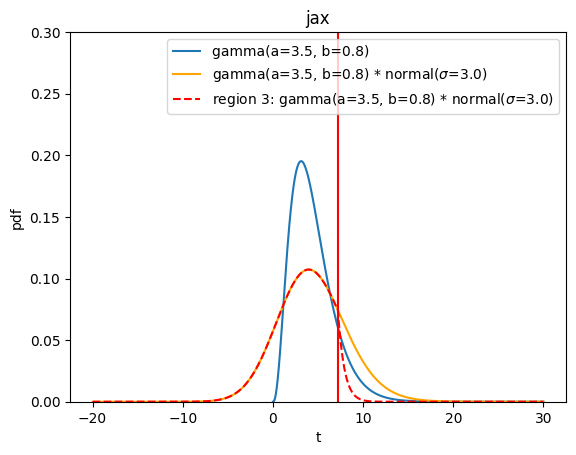

In [15]:
xvals = jnp.linspace(-20, 30, 10000)
yvals_jax = gamma_jax(xvals, gamma_a, gamma_b)
yvals_conv_jax = gamma_conv_jax(xvals, gamma_a, gamma_b, sigma=sigma)

fig, ax = plt.subplots()
ax.plot(xvals, yvals_jax, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.plot(xvals, yvals_conv_jax, 
        label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='orange')
ax.plot(xvals, yvals_conv_jax_region4, 
        label=f'region 3: gamma(a={gamma_a:.1f}, b={gamma_b:.1f}) * normal($\sigma$={sigma:.1f})', color='red', linestyle='dashed')

region3 = gamma_b*sigma**2
ax.axvline(region3, color='r')

ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.set_ylim([0.0, 0.3])
ax.legend()
ax.set_title('jax')
plt.show()

In [16]:
grad_region4 = jax.jit(jax.grad(gamma_conv_jax_region4, argnums=(0,1,2)))
grad_exact = jax.jit(jax.grad(gamma_conv_jax, argnums=(0,1,2)))

In [17]:
print(grad_region4(region3-1.e-5, gamma_a, gamma_b, sigma=sigma))
print(grad_exact(region3-1.e-5, gamma_a, gamma_b, sigma=sigma))

(Array(-0.01627278, dtype=float64, weak_type=True), Array(0.01805504, dtype=float64, weak_type=True), Array(-0.06355043, dtype=float64, weak_type=True))
(Array(-0.0162731, dtype=float64), Array(0.01803976, dtype=float64, weak_type=True), Array(-0.06359048, dtype=float64))


In [18]:
%timeit grad_region4(3.0, gamma_a, gamma_b, sigma=sigma)[0].block_until_ready()

98.4 µs ± 3.72 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%timeit grad_exact(3.0, gamma_a, gamma_b, sigma=sigma)[0].block_until_ready()

1.85 ms ± 7.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
